## Analysis of holtankoljak.hu station and gas price data

In [1]:
import sys 
sys.path.append('../../')

from src.import_packages import *
from src.visualize_EDA import vEDA

from ast import literal_eval
import re

import stylecloud
from IPython.display import Image, display

import statsmodels.api as sm

Importing the following packages: pandas, numpy, matplotlib, seaborn, plotly, warnings


In [2]:
data = pd.read_csv('data/scraped_data_20220113.csv')
data.head(3)

,link,address,geo_location,services,open_hours,prices
0,https://holtankoljak.hu/mol_siklos_felszabadul...,"Siklós, Felszabadulás út 1211/9 hrsz.","45.85673523,18.29270935","['UTA-kártya', ' kávé', ' bankkártya elfogadás...","['Hétfő:06:00 - 22:00', 'Kedd:06:00 - 22:00', ...","{'95-ös Benzin E10': '477.9,- Ft', 'Gázolaj': ..."
1,https://holtankoljak.hu/canada_petrol_kft__kec...,"Kecskemét, Felsőcsalános u. 54.","46.88845825,19.62286186","['autópálya-matrica', ' bankkártya elfogadás',...","['Hétfő:0-24 óráig', 'Kedd:0-24 óráig', 'Szerd...","{'95-ös Benzin E10': '479.9,- Ft', 'Gázolaj': ..."
2,https://holtankoljak.hu/ersto_kft__tokol_ledin...,"Tököl, Ledina dűlő 4.","47.31358337,18.97490311","['PB-gáz', ' mobiltelefon egyenlegfeltöltés', ...","['Hétfő:05:00 - 22:00', 'Kedd:05:00 - 22:00', ...","{'Gázolaj': '480.0,- Ft', '95-ös Benzin E10': ..."


### Clean up features

In [3]:
### GEO COORDS

data[['LAT', 'LON']] = data['geo_location'].str.split(',', expand = True).astype(float)
data.drop('geo_location', 1, inplace = True)

In [4]:
### PRICES

gas_types = pd.json_normalize(data['prices'].apply(eval))
gas_types.replace({'Nem ismert' : np.nan}, inplace = True)

NaN_count = gas_types.isnull().sum() / gas_types.shape[0]
keep_cols = NaN_count[NaN_count <= .75]
print('Keeping the following gas types:', keep_cols.index.tolist())

gas_types = gas_types[keep_cols.index.tolist()]

for i in gas_types.columns:
    gas_types[i] = gas_types[i].str.replace(',- Ft', '').astype(float)

data = pd.concat([data, gas_types], 1).drop(['prices'], 1)
data['Num_of_Gas_Types'] = 5 - gas_types.isnull().sum(axis=1)

Keeping the following gas types: ['95-ös Benzin E10', 'Gázolaj', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10']


In [5]:
### OPEN HOURS

hours = data['open_hours'].apply(eval).apply(pd.Series)
hours.columns = ['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']

for i in hours.columns:

    hours[i] = hours[i]\
                    .str.replace('Hétfő:', '')\
                    .str.replace('Kedd:', '')\
                    .str.replace('Szerda:', '')\
                    .str.replace('Csütörtök:', '')\
                    .str.replace('Péntek:', '')\
                    .str.replace('Szombat:', '')\
                    .str.replace('Vasárnap:', '')\
                    .str.replace('0-24 óráig', '00:00 - 24:00')\
                    .str.replace('00:00 - 23:59', '00:00 - 24:00')\
                    .str.replace('00:00 - 00:00', '00:00 - 24:00')\
                    .str.replace('Zárva', '00:00 - 00:00')\
                    .str.replace('06:00 - 02:00', '06:00 - 26:00')\
                    .str.replace('06:00 - 00:00', '06:00 - 24:00')

def calc_hours_open(_time):
    
    OPEN = _time.split(' - ')[0]
    OPEN_CONV = int(OPEN.split(':')[0]) + int(OPEN.split(':')[1]) / 60

    CLOSE = _time.split(' - ')[1]
    CLOSE_CONV = int(CLOSE.split(':')[0]) + int(CLOSE.split(':')[1]) / 60

    HOURS_OPEN = CLOSE_CONV - OPEN_CONV

    return HOURS_OPEN

for i in hours.columns:
    hours[i] = hours[i].apply(lambda x: calc_hours_open(x))

data = pd.concat([data, hours], 1).drop(['open_hours'], 1)
data = data[data['Hétfő'] != 0]

In [6]:
data['Open_7-24'] = 0
data.loc[data[hours.columns].eq(24).all(1), 'Open_7-24'] = 1

In [7]:
### LINK

brands = pd.DataFrame(data['link'].str.replace('https://holtankoljak.hu/', '').str.split('_', expand = True)[0])

brand_mapper = {'mobil' : 'mobil-petrol', 'mol-partner' : 'mol', 'oil' : 'oil!'}
brands[0].replace(brand_mapper, inplace = True)

brand_keep = brands[0].value_counts().head(10).index.tolist()
brands.loc[~brands[0].isin(brand_keep), 0] = 'magan'
brands.columns = ['brand']

data = pd.concat([data, brands], 1)

In [8]:
### BUDAPEST or NOT

data['Budapest'] = 0
data.loc[data['link'].str.contains('budap'), 'Budapest'] = 1
#data.drop('link', 1, inplace = True)

In [9]:
### AUTOPALYA or not

data['Highway'] = 0
data.loc[(data['address'].str.lower().str.contains('km')) | 
          (data['address'].str.lower().str.contains('autópálya')) | 
          (data['address'].str.lower().str.contains('m1|m2|m2|m4|m5|m6|m7')), 'Highway'] = 1
#data.drop('address', 1, inplace = True)

In [10]:
### SERVICES

data['Num_of_Services'] = data['services'].apply(eval).apply(lambda x: len(set(x)))
all_services = data['services'].apply(eval).apply(lambda x: [i.strip() for i in x if i != '']).tolist()

all_services_flat = [item for sublist in all_services for item in sublist]
all_services_set = list(set(all_services_flat))

print('Number of total unique services available:', len(all_services_set))

Number of total unique services available: 48


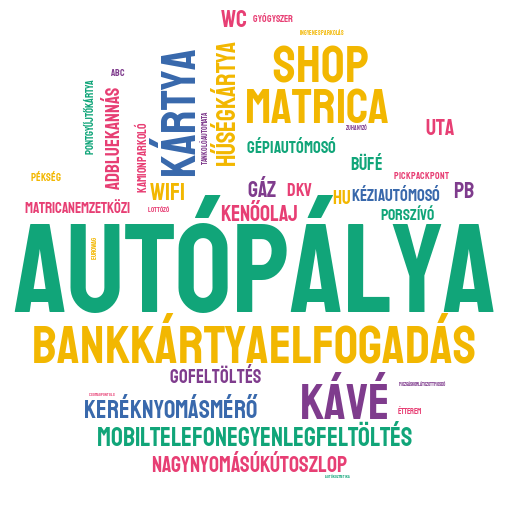

In [12]:
wc_data = ' '.join([i.replace(' ', '') for i in all_services_flat])

stylecloud.gen_stylecloud(wc_data, max_words = 750, max_font_size = 350, icon_name = 'fas fa-circle',
                          output_name = 'data/2/services.png', collocations = False)

display(Image(filename = 'data/2/services.png', width = 450))

## Distributions

In [13]:
v = vEDA(data)
print(v)

EDA visualizations for given Pandas DataFrame


In [14]:
v.plot_geo_map('LAT', 'LON', zoom = 6, color_by='brand')

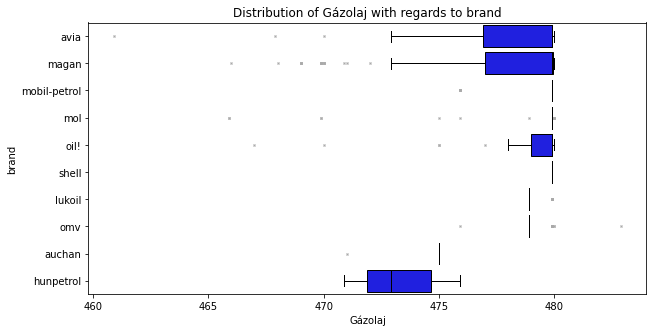

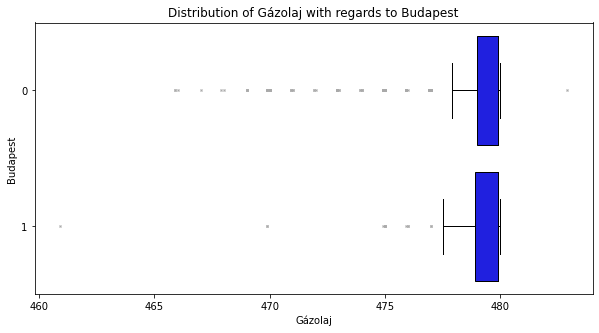

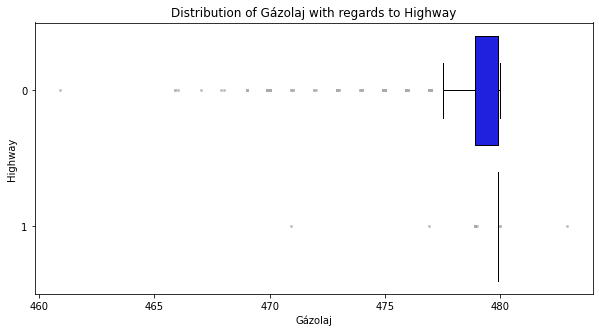

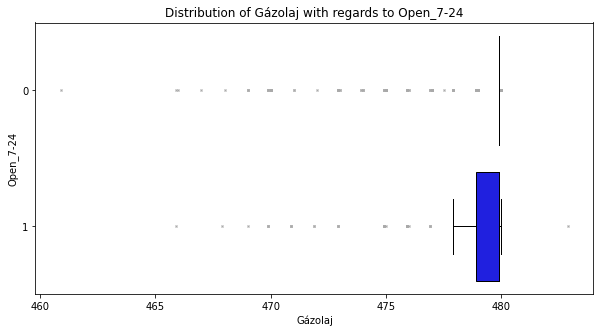

In [16]:
for i in ['brand', 'Budapest', 'Highway', 'Open_7-24']:
            v.plot_boxplot('Gázolaj', i)

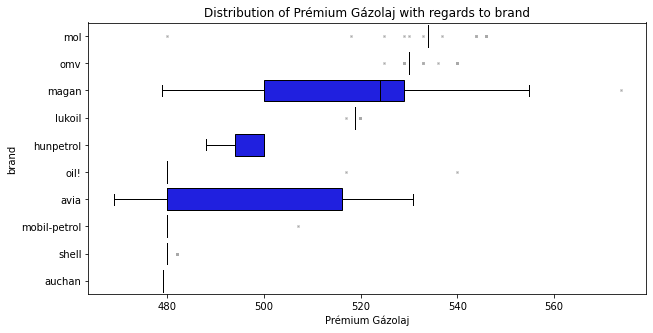

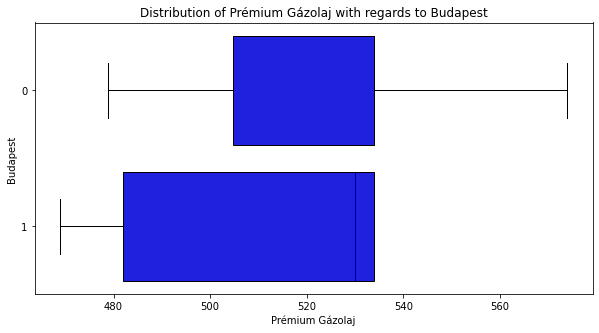

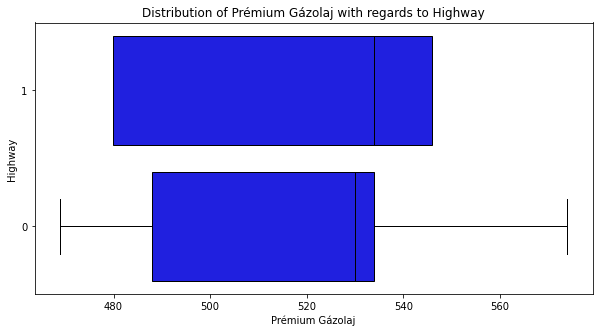

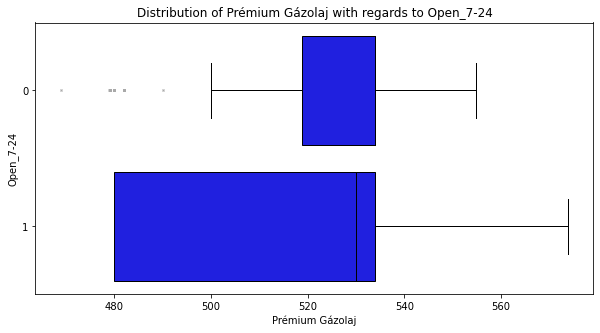

In [15]:
for i in ['brand', 'Budapest', 'Highway', 'Open_7-24']:
            v.plot_boxplot('Prémium Gázolaj', i)

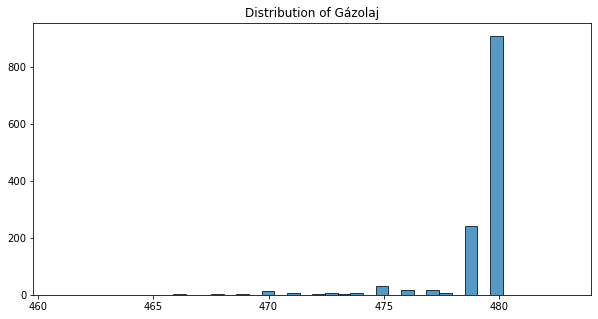

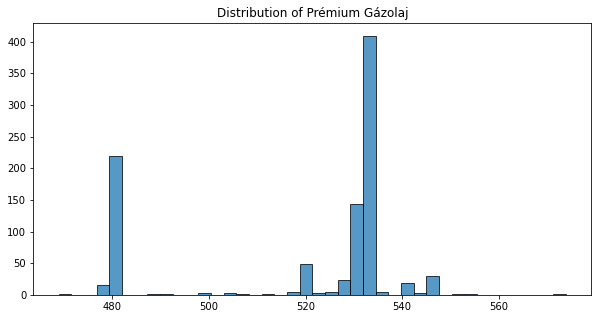

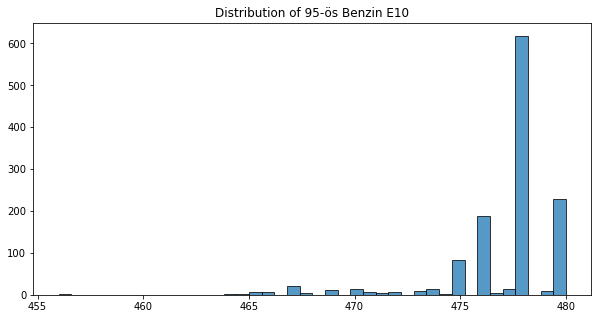

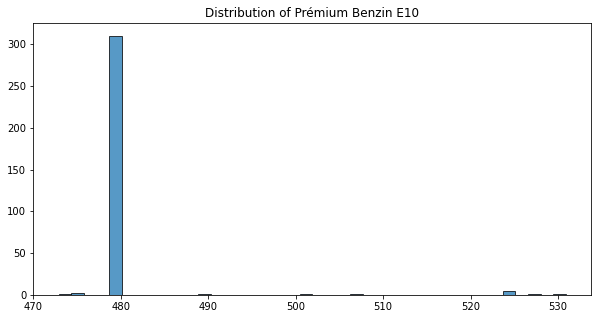

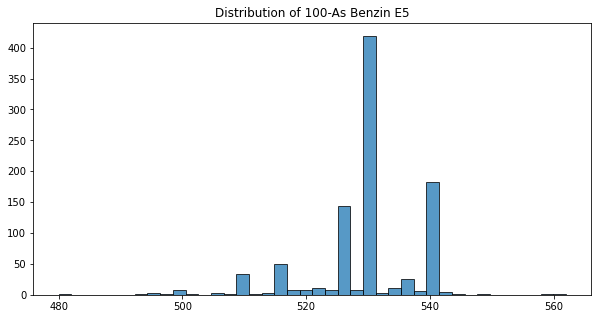

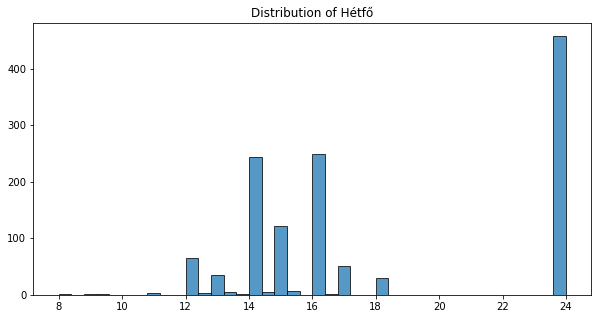

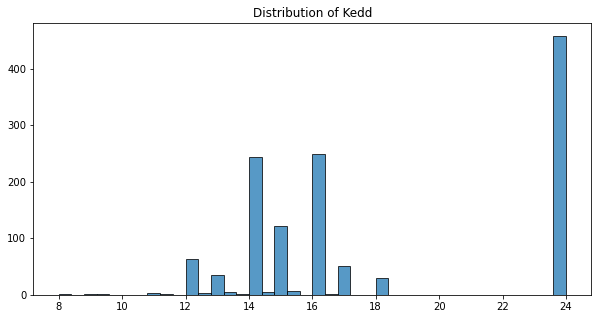

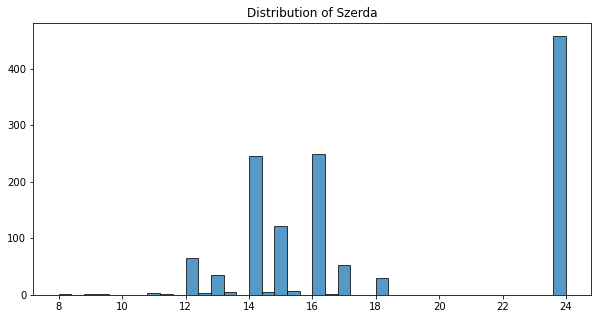

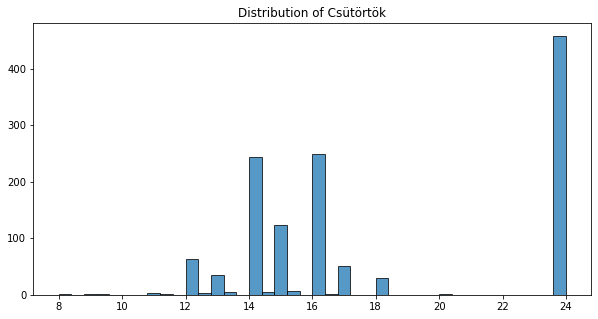

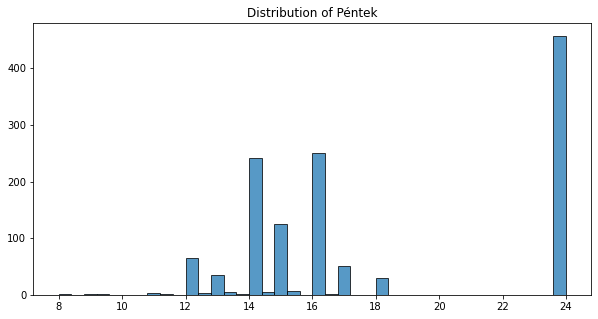

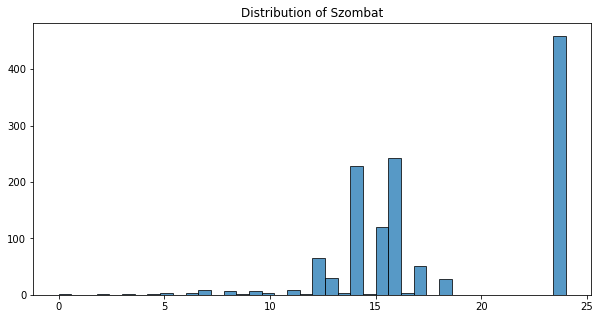

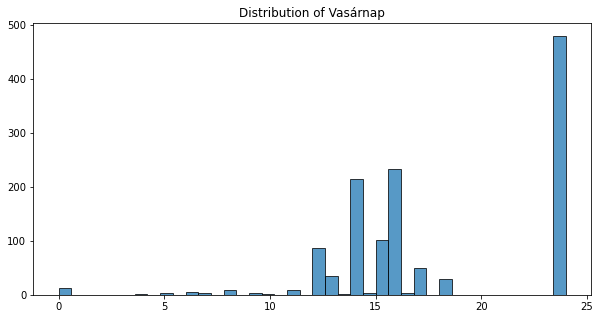

In [17]:
for i in ['Gázolaj', 'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5', 
            'Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap']:
       v.plot_dist(i)

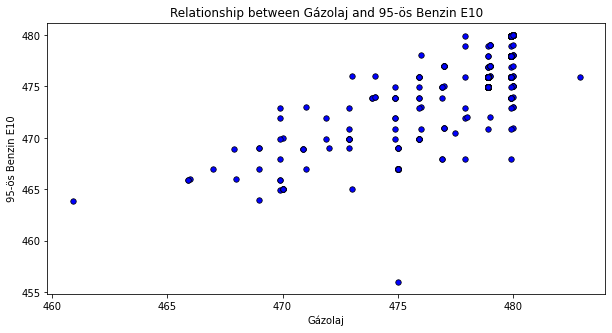

In [18]:
v.plot_scatter('Gázolaj', '95-ös Benzin E10')

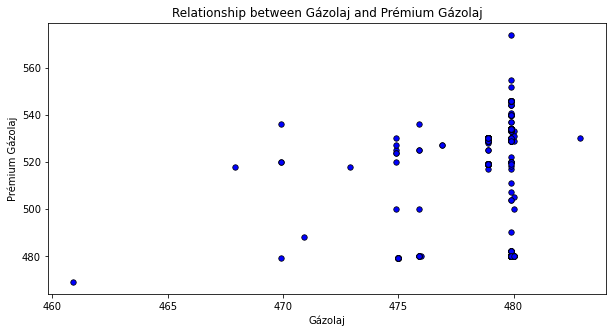

In [19]:
v.plot_scatter('Gázolaj', 'Prémium Gázolaj')

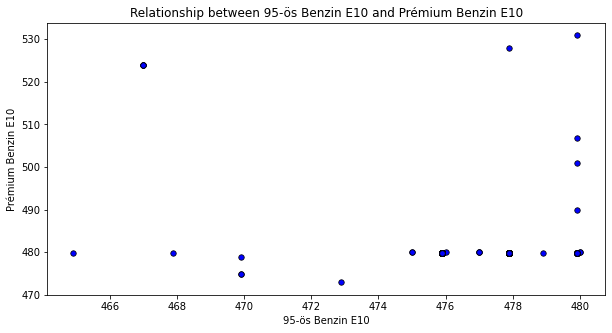

In [20]:
v.plot_scatter('95-ös Benzin E10', 'Prémium Benzin E10')

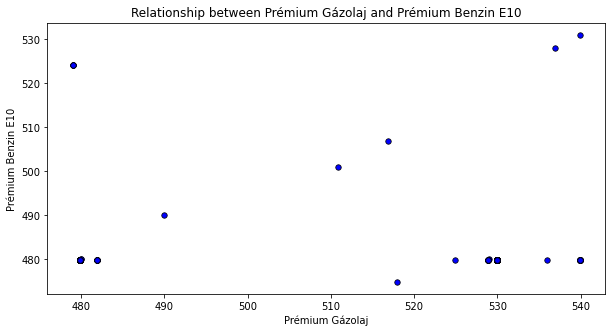

In [21]:
v.plot_scatter('Prémium Gázolaj', 'Prémium Benzin E10')

### Correlation

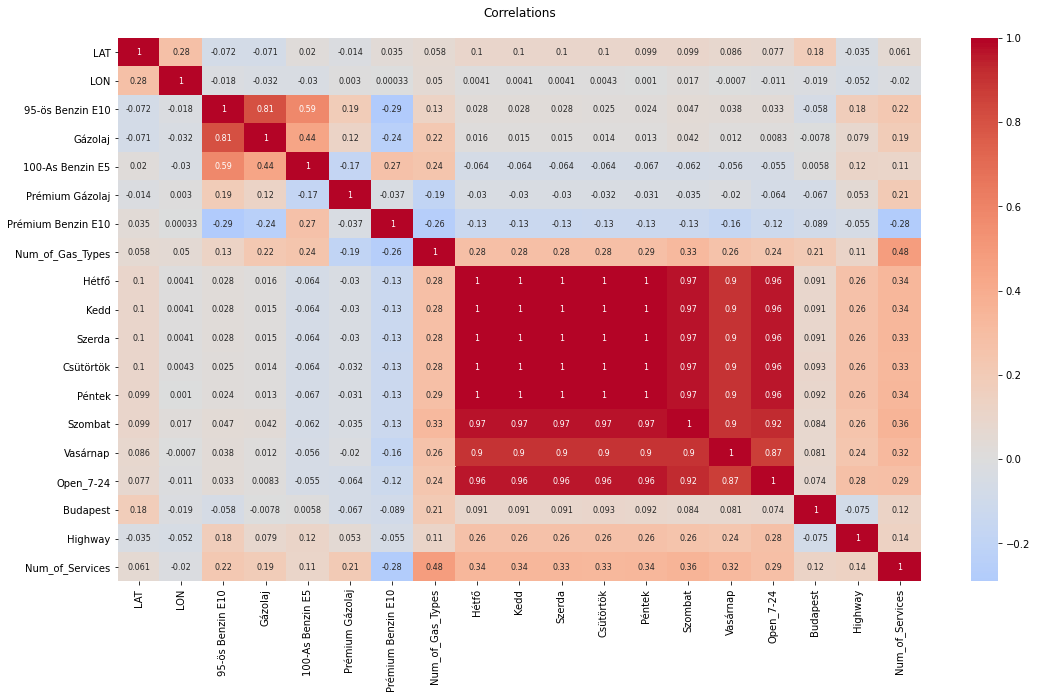

In [22]:
v.plot_corr()

### Connection between services and brands

In [170]:
crosstab_analysis = data[['brand', 'services']].copy()

pivoted = (crosstab_analysis
    .set_index('brand')
    .services.apply(eval)
    .apply(lambda x: list(set(x)))
    .apply(lambda x: [ i.strip() for i in x if i != ''])
    .apply(lambda x: ','.join(x))
    .str.split(',', expand = True)
    .stack()
    .reset_index()
    .pivot_table(index = 'brand', columns = 0, fill_value = 0, aggfunc = 'size')
)

drop_services = pivoted.sum()[pivoted.sum().sort_values() <= 50].index.tolist()

pivoted = (crosstab_analysis
    .set_index('brand')
    .services.apply(eval)
    .apply(lambda x: list(set(x)))
    .apply(lambda x: [ i.strip() for i in x if i != ''])
    .apply(lambda x: [ i for i in x if i not in drop_services])
    .apply(lambda x: ','.join(x))
    .str.split(',', expand = True)
    .stack()
    .reset_index()
    .pivot_table(index = 'brand', columns = 0, fill_value = 0, aggfunc = 'size')
)


In [171]:
pivoted

,,ABC,AdBlue kannás,DKV-kártya,Eurowag-kártya,Gyógyszer,HU-GO feltöltés,Lottózó,PB-gáz,Pick Pack Pont,...,kávé,kézi autómosó,mobiltelefon egyenlegfeltöltés,nagynyomású kútoszlop,pontgyűjtő kártya,porszívó,pékség,shop,tankoló automata,Étterem
brand,,,,,,,,,,,,,,,,,,,,,
auchan,0,0,0,0,0,0,0,0,17,0,...,0,0,0,0,0,0,0,0,18,0
avia,0,5,15,8,15,3,12,2,36,1,...,35,14,36,15,5,16,4,37,3,0
hunpetrol,0,0,1,0,0,0,2,1,0,0,...,1,1,8,0,0,1,0,1,9,0
lukoil,0,22,10,76,0,0,23,0,2,0,...,78,11,57,0,0,12,21,79,2,0
magan,8,8,52,25,24,0,52,8,117,1,...,149,51,111,68,0,50,6,157,22,10
mobil-petrol,0,1,0,0,4,0,28,1,21,0,...,45,31,33,14,0,22,0,43,10,1
mol,0,9,139,94,1,132,130,51,320,122,...,419,153,443,327,5,48,128,466,6,12
oil!,0,0,5,11,14,0,10,2,29,0,...,43,12,41,14,0,11,0,43,5,4
omv,0,72,9,165,4,0,76,0,41,5,...,172,59,29,121,140,135,1,178,2,35


## Modeling (Premium) Diesel prices with simple OLS

### Baseline model without services, other fuel types, geo data

In [41]:
Y = 'Prémium Gázolaj'
p_signif = 0.01

In [42]:
abt = data.copy()

if Y == 'Gázolaj':
    abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'services', 'LAT', 'LON',
            'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5'], 1, inplace = True) 
    abt = abt[abt['Gázolaj'].notnull()]

if Y == 'Prémium Gázolaj':
    abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'services', 'LAT', 'LON',
            'Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5'], 1, inplace = True) 
    abt = abt[abt['Prémium Gázolaj'].notnull()]


abt_dummified = pd.get_dummies(abt, columns=['brand'], prefix_sep=' = ').drop(['brand = magan'], 1)
abt_dummified.dropna(inplace = True)

In [43]:
X = abt_dummified.drop([Y], 1)
X = sm.add_constant(X)
y = abt_dummified[Y]

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= p_signif]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [44]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Prémium Gázolaj   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     1020.
Date:                Thu, 13 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:59:00   Log-Likelihood:                -3083.4
No. Observations:                 939   AIC:                             6191.
Df Residuals:                     927   BIC:                             6249.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  519.2548      1.157    448.747      0.000     516.984     521.526
Open_7-24                1.5928      0.495      3.217      0.001       0.621       2.565
Highway                  5.1445      0.773      6.653      0.000       3.627       6.662
Num_of_Services         -0.2127      0.074     -2.855      0.004      -0.359      -0.067
brand = auchan         -39.1062      1.899    -20.597      0.000     -42.832     -35.380
brand = avia           -22.1069      1.923    -11.499      0.000     -25.880     -18.334
brand = hunpetrol      -24.0259      3.889     -6.178      0.000     -31.657     -16.394
brand = mobil-petrol   -38.1381      1.246    -30.603      0.000     -40.584     -35.692
brand = mol             17.4232      0.794     21.938      0.000      15.865      18.982
brand = oil!           -28.5515      2.091    -13.655      0.000     -32.655     -24.448
brand = omv             13.6350      0.931     14.641      0.000      11.807      15.463
brand = shell          -37.5991      0.886    -42.424      0.000     -39.338     -35.860
==============================================================================
Omnibus:                      279.197   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30023.726
Skew:                           0.049   Prob(JB):                         0.00
Kurtosis:                      30.701   Cond. No.                         273.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Adding all services as dummies

In [172]:
abt = data.copy()

if Y == 'Gázolaj':
    abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'LAT', 'LON',
            'Prémium Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5'], 1, inplace = True) 
    abt = abt[abt['Gázolaj'].notnull()]

if Y == 'Prémium Gázolaj':
    abt.drop(['Hétfő', 'Kedd', 'Szerda', 'Csütörtök', 'Péntek', 'Szombat', 'Vasárnap', 'link', 'address', 'LAT', 'LON',
            'Gázolaj', '95-ös Benzin E10', 'Prémium Benzin E10', '100-As Benzin E5'], 1, inplace = True) 
    abt = abt[abt['Prémium Gázolaj'].notnull()]

abt_dummified = pd.get_dummies(abt, columns=['brand'], prefix_sep=' = ').drop(['brand = magan'], 1)
abt_dummified.dropna(inplace = True)

In [173]:
services_dummified = abt_dummified.services.apply(eval).apply(lambda x: list(set(x))).apply(lambda x: [ i.strip() for i in x if i != '']).apply(lambda x: [ i for i in x if i not in drop_services]).str.join('|').str.get_dummies()

#services_dummified.loc[services_dummified['ATM automata'] != services_dummified['ATM-automata'], 'ATM automata'] = services_dummified.loc[services_dummified['ATM automata'] != services_dummified['ATM-automata'], 'ATM-automata']
#services_dummified.drop(['ATM-automata'], 1, inplace = True)

In [174]:
abt_dummified = pd.concat([abt_dummified, services_dummified], 1).drop('services', 1)

In [175]:
X = abt_dummified.drop([Y], 1)
X = sm.add_constant(X)
y = abt_dummified[Y]

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= p_signif]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [176]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Prémium Gázolaj   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     837.2
Date:                Fri, 14 Jan 2022   Prob (F-statistic):               0.00
Time:                        00:40:48   Log-Likelihood:                -3063.1
No. Observations:                 939   AIC:                             6156.
Df Residuals:                     924   BIC:                             6229.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  519.1216      1.220    425.410      0.000     516.727     521.516
Open_7-24                1.3975      0.491      2.848      0.004       0.435       2.360
Highway                  4.9026      0.762      6.437      0.000       3.408       6.397
Num_of_Services         -0.3675      0.078     -4.693      0.000      -0.521      -0.214
brand = auchan         -45.5551      2.378    -19.158      0.000     -50.222     -40.888
brand = avia           -22.0752      1.889    -11.684      0.000     -25.783     -18.367
brand = hunpetrol      -27.0786      4.089     -6.622      0.000     -35.104     -19.053
brand = mobil-petrol   -38.1853      1.256    -30.410      0.000     -40.650     -35.721
brand = mol             15.8631      0.838     18.921      0.000      14.218      17.508
brand = oil!           -27.0797      2.082    -13.004      0.000     -31.167     -22.993
brand = omv             13.3692      0.945     14.152      0.000      11.515      15.223
brand = shell          -38.4383      0.903    -42.586      0.000     -40.210     -36.667
Gyógyszer                2.5905      0.718      3.609      0.000       1.182       3.999
hűségkártya              3.3659      0.715      4.710      0.000       1.963       4.768
tankoló automata         4.0518      1.452      2.790      0.005       1.202       6.901
==============================================================================
Omnibus:                      288.944   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28508.069
Skew:                           0.289   Prob(JB):                         0.00
Kurtosis:                      29.987   Cond. No.                         302.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion: 
- adding service indicators increased adj R2 from 91.4 to 92.5
- most influence: **BRAND**, **number of services**, **couple of services (flowers, motel, free charging, paid parking)**